In [1]:
import pandas as pd
import geopandas as gpd
import sqlite3
from shapely import wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, Polygon
from geovoronoi import voronoi_regions_from_coords

/usr/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
agglomeration = gpd.read_file("input/agglomeration_border.geojson")


cells = pd.read_csv("dummy_data/cells.csv")
cells["geometry"] = cells["geometry"].apply(wkt.loads)
cells = gpd.GeoDataFrame(cells, geometry="geometry", crs=4326)
cells.rename({"cid": "cell_id"}, axis=1, inplace=True)


In [3]:
cells

,radio,mcc,mnc,lac,cell_id,lon,lat,range,samples,created,updated,geometry
0,GSM,216,70,141,12142,19.284950,47.297036,39621,1999,1317853422,1515062886,POINT (19.28495 47.29704)
1,GSM,216,70,141,12151,19.269680,47.343904,25773,383,1317853422,1515063475,POINT (19.26968 47.34390)
2,GSM,216,70,141,14765,19.277820,47.285802,22136,1188,1317853422,1618193051,POINT (19.27782 47.28580)
3,GSM,216,70,141,12152,19.291631,47.297692,11950,1204,1317854261,1515062696,POINT (19.29163 47.29769)
4,GSM,216,70,141,14764,19.224429,47.341574,22578,1462,1317854261,1571281991,POINT (19.22443 47.34157)
...,...,...,...,...,...,...,...,...,...,...,...,...
3987,UMTS,216,70,235,2698548,19.155275,47.605460,1969,390,1613229242,1640668373,POINT (19.15527 47.60546)
3988,UMTS,216,70,3111,267276,18.934753,47.459028,3809,327,1621498140,1648376182,POINT (18.93475 47.45903)
3989,UMTS,216,70,3111,447500,18.932141,47.457515,1276,297,1621498243,1647764986,POINT (18.93214 47.45752)
3990,UMTS,216,70,3115,454155,19.042941,47.466129,944,390,1632393634,1653712405,POINT (19.04294 47.46613)


# Getting weights

As the real data is considerably large, it is stored and queried in a RDBMS (PostgreSQL). In this notebook, is mocked by an in-memory sqlite database.

```sql
SELECT cell_id, count(*) AS count
FROM cdr
GROUP BY cell_id
ORDER by cell_id
```

In [4]:
# read the dumm CDR
cdr = pd.read_csv("dummy_data/cdr.csv")

# create in-memory database
db = sqlite3.connect(":memory:")

# drop the cdr table if already exists
db.execute("DROP TABLE IF EXISTS cdr")

# load dummy CDR to the in-memory database
cdr.to_sql("cdr", db)

2279095

In [5]:
query = """
    SELECT cell_id, count(*) AS count
    FROM cdr
    GROUP BY cell_id
    ORDER by cell_id
    """

cell_activity = pd.read_sql(query, db)
cells = cells.merge(cell_activity, on="cell_id", how="left")
cells["count"] = cells["count"].fillna(0)

# Apply DBSCAN

But before, reproject to EPSG:23700, which is for Hungary and uses meter for unit

In [6]:
cells_projected = cells.to_crs(23700)
cells_projected

,radio,mcc,mnc,lac,cell_id,lon,lat,range,samples,created,updated,geometry,count
0,GSM,216,70,141,12142,19.284950,47.297036,39621,1999,1317853422,1515062886,POINT (667961.878 217025.865),522
1,GSM,216,70,141,12151,19.269680,47.343904,25773,383,1317853422,1515063475,POINT (666792.292 222232.796),589
2,GSM,216,70,141,14765,19.277820,47.285802,22136,1188,1317853422,1618193051,POINT (667426.311 215775.385),498
3,GSM,216,70,141,12152,19.291631,47.297692,11950,1204,1317854261,1515062696,POINT (668466.925 217100.342),504
4,GSM,216,70,141,14764,19.224429,47.341574,22578,1462,1317854261,1571281991,POINT (663373.625 221965.086),556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,UMTS,216,70,235,2698548,19.155275,47.605460,1969,390,1613229242,1640668373,POINT (658107.931 251293.066),1077
3988,UMTS,216,70,3111,267276,18.934753,47.459028,3809,327,1621498140,1648376182,POINT (641503.163 235014.040),521
3989,UMTS,216,70,3111,447500,18.932141,47.457515,1276,297,1621498243,1647764986,POINT (641305.972 234846.124),520
3990,UMTS,216,70,3115,454155,19.042941,47.466129,944,390,1632393634,1653712405,POINT (649660.415 235797.255),549


## Applying Voronoi tessellation before merge

/usr/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


<AxesSubplot:>

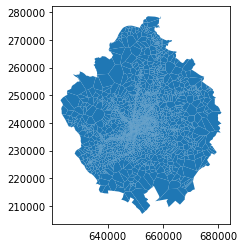

In [7]:
region_polys, region_pts = voronoi_regions_from_coords(cells_projected.geometry, agglomeration.to_crs(23700).geometry[0])
voronoi_before_merged = gpd.GeoDataFrame.from_dict({"cell_id": region_polys.keys(), "geometry": region_polys.values()})
voronoi_before_merged = voronoi_before_merged.set_crs(23700)

voronoi_before_merged.plot()

In [8]:
points = [[row.geometry.x, row.geometry.y] for row in cells_projected.itertuples()]
db = DBSCAN(eps=100, min_samples=1, metric="euclidean").fit_predict(points, sample_weight=cells["count"])
cells_projected["cell_id_new"] = db
cells_projected["cell_id_new"] = cells_projected["cell_id_new"] + 1
# cells = cells.drop_duplicates(subset=["cell_id_new"], keep="first")

Forming a lookup table for the future CDR modification. Optionally saving to a JSON file.

In [9]:
lookup = {x.cell_id: x.cell_id_new for x in cells_projected.itertuples()}

# import json
# with open("output/cell_id_lookup.json", "w") as fp:
#     json.dump(lookup, fp)

In [10]:
cells_merged = cells_projected.drop_duplicates(subset=["cell_id_new"], keep="first")

## Applying Voronoi tessellation after merge

/usr/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


<AxesSubplot:>

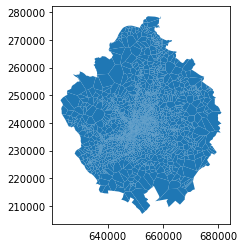

In [11]:
region_polys, region_pts = voronoi_regions_from_coords(cells_merged.geometry, agglomeration.to_crs(23700).geometry[0])
voronoi_after_merged = gpd.GeoDataFrame.from_dict({"cell_id": region_polys.keys(), "geometry": region_polys.values()})
voronoi_after_merged = voronoi_after_merged.set_crs(23700)

voronoi_after_merged.plot()

## Download buildings from OSM

Using osmnx package.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from matplotlib.colors import to_hex
ox.config(use_cache=True, log_console=False)


bbox = 19.0297, 47.4897, 19.0621, 47.5098  # minX, minY, maxX, maxY
zoom = 16

ox_bbox = bbox[3], bbox[1], bbox[0], bbox[2]
buildings = ox.geometries_from_bbox(*ox_bbox, tags={"building": True})
buildings["is_point"] = buildings["geometry"].apply(isinstance, args=(Point,))
buildings = buildings.query("~is_point")

bridge_names = ["Széchenyi lánchíd", "Erzsébet híd"]
bridges = ox.geometries_from_bbox(*ox_bbox, tags={"name": bridge_names})
bridges = bridges.query("~osmid.isin([5441992758])")

g = ox.graph_from_bbox(*ox_bbox)

streets = ox.graph_to_gdfs(g, nodes=False)

area = Polygon([Point(bbox[0], bbox[1]), Point(bbox[2], bbox[1]),
                Point(bbox[2], bbox[3]), Point(bbox[0], bbox[3]),
                Point(bbox[0], bbox[1])])
area_eov = gpd.GeoDataFrame(geometry=[area], crs=4326).to_crs(23700)

duna = gpd.read_file("input/duna.geojson", crs=23700)
land = gpd.GeoSeries(area.difference(duna.to_crs(4326).unary_union), name="geometry")

land = gpd.GeoDataFrame(land, crs=4326).to_crs(23700)
bridges.to_crs(23700, inplace=True)
streets.set_crs(4326)
streets.to_crs(23700, inplace=True)
buildings.set_crs(4326)
buildings.to_crs(23700, inplace=True)

# Plotting Figure 6

Text(0.5, 1.0, 'Voronoi polygons after merge')

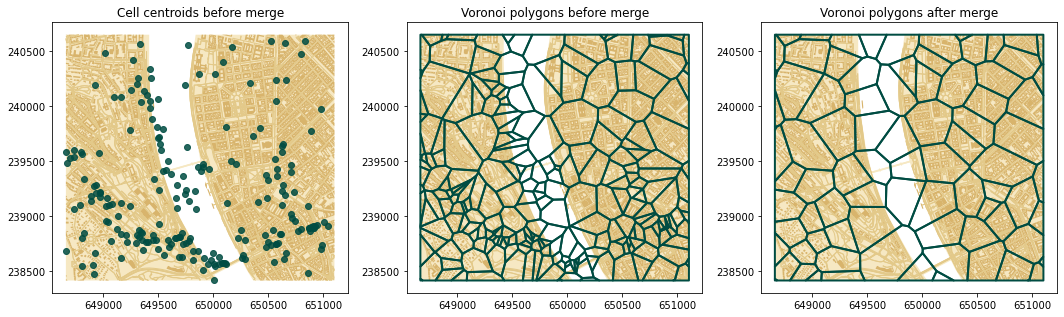

In [13]:
COLORS = sns.color_palette("BrBG", 24)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for ax in axes:
    land.plot(color=COLORS[9], ax=ax)
    bridges.plot(color=COLORS[9], ax=ax)

    gpd.clip(streets, area_eov).plot(color=COLORS[7], linewidth=1, ax=ax)
    gpd.clip(buildings, area_eov).plot(color=COLORS[6], ax=ax)

gpd.clip(cells.to_crs(23700), area_eov).plot(ax=axes[0], color=COLORS[23], alpha=0.85, zorder=10)
gpd.clip(voronoi_before_merged, area_eov)\
   .plot(color=to_hex(COLORS[23])+"00", ax=axes[1], edgecolor=COLORS[23], linewidth=2, zorder=10)
gpd.clip(voronoi_after_merged, area_eov)\
   .plot(color=to_hex(COLORS[23])+"00", ax=axes[2], edgecolor=COLORS[23], linewidth=2, zorder=10)
axes[0].set_title("Cell centroids before merge")
axes[1].set_title("Voronoi polygons before merge")
axes[2].set_title("Voronoi polygons after merge")
